<br>

More about data science: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Linear regression with Python](https://cienciadedatos.net/documentos/py17-linear-regression-python.html)
+ [Logistic regression with Python](https://cienciadedatos.net/documentos/py17-logistic-regression-python.html)
+ [Random forest](https://www.cienciadedatos.net/documentos/py08_random_forest_python_en.html)

<br>

<div style="text-align: center;">
    <img src="https://cienciadedatos.net/images/logo-web-cienciadedatos.png" style="display: block; margin: 0 auto; width: 360px; height: auto;">
</div>

# Introduction

Deep learning models have become the reference standard across many fields—one of them being computer vision, also known as artificial vision. A widely expanding application of this technology is facial recognition, that is, the automated identification of people appearing in an image or video.

Similar to how humans do it, for a computer system to be able to identify the people shown in an image, several stages are required:

1. Detect the faces in the image.

2. Use a neural network capable of mapping the features of a human face into a numerical representation. This step is known as *embedding* or *encoding*.

3. Measure the similarity between the numerical representation of the detected faces and the reference representations available in a database.

4. Determine whether they are sufficiently similar to be considered the same person and assign the corresponding identity.

Throughout this document, each of these steps is described and applied using [DeepFaceRecognition](https://github.com/JoaquinAmatRodrigo/deep-face-recognition), a Python package developed by the author of this document that provides tools for face detection and recognition using deep learning.

<div align="center">
<img src="../images/diagram-face-recognition.png" style="width: 900px;">
</div>

<center><font size='2.5'> <i>Diagram of the steps followed in a facial recognition system.</i></font></center>

# Libraries and data

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

/home/joaquin/Documents/GitHub/openfacekit


In [2]:
# Data manipulation
# ==============================================================================
import os
import urllib
import zipfile
import numpy as np
from urllib.request import urlretrieve

# Image processing
# ==============================================================================
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Models
# ==============================================================================
import torch
from scipy.spatial.distance import euclidean
from openfacekit import (
    FaceRecognizer,
    convert_to_matplotlib_rgb,
    ReferenceEmbeddings,
)

For the examples in this document, images of the actors from the hilarious series *Modern Family* are used. As a first step, the images are downloaded into a local folder. This can be easily done in Python using the `urlretrieve` function from the **urllib** library.

In [3]:
# Download images
# ==============================================================================
if not os.path.exists('images'):
    os.makedirs('images')
# Image with a single face
url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'raw/master/images/phil_dunphy.jpg')
urlretrieve(url=url, filename='images/image_1.jpg')

# Image with multiple faces
url = ('https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
       'raw/master/images/modernfamily.jpg')
urlretrieve(url=url, filename='images/image_2.png');

There are several libraries in Python that allow image processing (reading, writing, resizing, cropping, etc.). Three of the most commonly used are **OpenCV** (`cv2`), **PIL**, and **matplotlib**. It is important to note that OpenCV uses the BGR color format, while PIL and matplotlib use RGB. Fortunately, it is easy to switch between these formats using the functions `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)` and `cv2.cvtColor(image, cv2.COLOR_RGB2BGR)`.

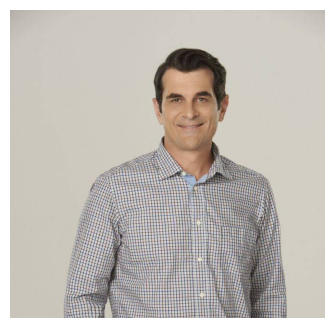

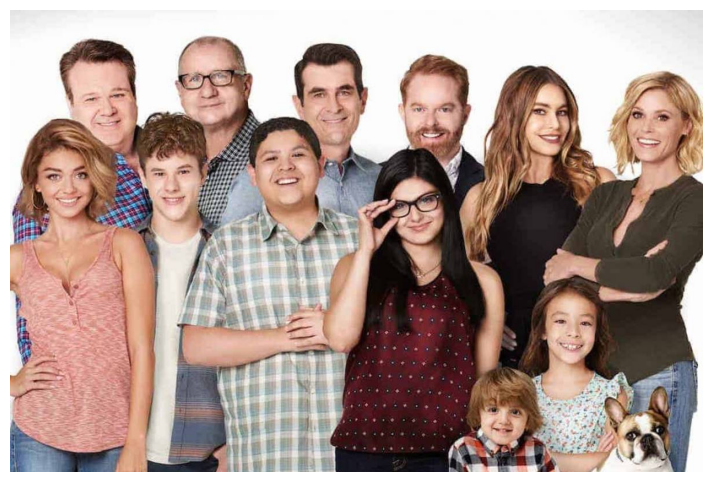

In [4]:
# Reading images
# ==============================================================================
image_1 = Image.open('./images/image_1.jpg')
image_2 = Image.open('./images/image_2.png')

# image_1 = cv2.imread('images/image_1.jpg')
# image_2 = cv2.imread('images/image_2.png')

# Plot images
# ==============================================================================
plt.figure(figsize=(5, 4))
plt.imshow(image_1)
plt.axis('off')

plt.figure(figsize=(10, 6))
plt.imshow(image_2)
plt.axis('off');

# Face detection


The first step in the facial recognition process is to detect where faces are located within an image. Many strategies and detection methods have been developed since the early research in this field, two of the most notable ones being:

+ [*MultiTask Cascaded Convolutional Neural Network (MTCNN)*](https://arxiv.org/abs/1604.02878): This detector combines three neural network models that sequentially refine the detections. Several MTCNN detectors are available for Python. One of the most efficient implementations uses [PyTorch](https://pytorch.org/) and is accessible via the [facenet-pytorch](https://github.com/timesler/facenet-pytorch) library.

+ [YuNet](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html): a Convolutional Neural Network (CNN) based face detector developed by Shiqi Yu in 2018 and open-sourced in 2019. It is optimized for real-time applications and is included in OpenCV since version 4.5.1.

DeepFaceRecognition includes implementations of both detectors, allowing users to choose the one that best suits their needs.

In [5]:
# Initialize face detector
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
face_detector = FaceRecognizer(
    detector = "MTCNN", #"OpenCV_Yunet",
    encoder = None,
    device = "cpu",
    min_face_size = 20,
    thresholds = [0.6, 0.7, 0.7],
    min_confidence_detector = 0.5,
    similarity_threshold = 0.5,
    similarity_metric = "cosine",
    keep_all = True,
    verbose = True
)
face_detector

--------------
FaceRecognizer
--------------
Detector type: MTCNN
Encoder type: InceptionResnetV1
Device: cpu
Number of reference identities: 0
Similarity metric: cosine
Similarity threshold: 0.5
Minimum confidence detector: 0.5

## Bounding boxes detection

The method `detect_bboxes` of the `FaceDetector` class is used to detect the bounding boxes of the faces present in an image. This method returns the coordinates of the bounding boxes and their associated probabilities.

In [6]:
# Detection of bounding boxes and its probabilities
# ==============================================================================
boxes, probs = face_detector.detect_bboxes(
    image    = image_2,
    fix_bbox = True
)
boxes

----------------
Scanned image
----------------
Detected faces: 12
Detected faces with minimum confidence: 12
Bounding box correction applied: True
Bounding box coordinates: [[293, 64, 402, 194], [505, 89, 605, 224], [108, 95, 210, 227], [427, 207, 529, 333], [47, 235, 145, 361], [1069, 134, 1165, 262], [682, 126, 778, 248], [659, 291, 750, 402], [886, 128, 968, 250], [239, 245, 326, 355], [931, 496, 1012, 613], [816, 663, 889, 751]]
Bounding box confidence: [0.9999438524246216, 0.9982789754867554, 0.999267041683197, 0.9998809099197388, 0.9999357461929321, 0.9999068975448608, 0.9999818801879883, 0.9996474981307983, 0.9995021820068359, 0.9993504881858826, 0.9991905093193054, 0.9989155530929565]



array([[ 293,   64,  402,  194],
       [ 505,   89,  605,  224],
       [ 108,   95,  210,  227],
       [ 427,  207,  529,  333],
       [  47,  235,  145,  361],
       [1069,  134, 1165,  262],
       [ 682,  126,  778,  248],
       [ 659,  291,  750,  402],
       [ 886,  128,  968,  250],
       [ 239,  245,  326,  355],
       [ 931,  496, 1012,  613],
       [ 816,  663,  889,  751]])

It is common to plot the detected bounding boxes on the original image to visually verify the detection results. This can be done using `detect_faces` method of the `FaceDetector` class.

----------------
Scanned image
----------------
Detected faces: 12
Detected faces with minimum confidence: 12
Bounding box correction applied: True
Bounding box coordinates: [[293, 64, 402, 194], [505, 89, 605, 224], [108, 95, 210, 227], [427, 207, 529, 333], [47, 235, 145, 361], [1069, 134, 1165, 262], [682, 126, 778, 248], [659, 291, 750, 402], [886, 128, 968, 250], [239, 245, 326, 355], [931, 496, 1012, 613], [816, 663, 889, 751]]
Bounding box confidence: [0.9999438524246216, 0.9982789754867554, 0.999267041683197, 0.9998809099197388, 0.9999357461929321, 0.9999068975448608, 0.9999818801879883, 0.9996474981307983, 0.9995021820068359, 0.9993504881858826, 0.9991905093193054, 0.9989155530929565]



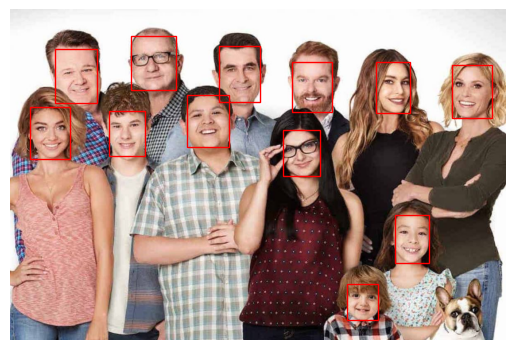

In [7]:
# Plot detected bounding boxes on the original image
# ==============================================================================
face_detector.detect_faces(
    image    = image_2,
    fix_bbox = True
)

## Extract detected faces

The method `extract_faces` of the `FaceDetector` class is used to extract the portions of the image that contain faces. The returned object is a tensor with the pixel values of the cropped faces (3 color channels x image_size x image_size). If more than one face is detected, then a tensor of dimensions (number of faces x 3 color channels x image_size x image_size) is returned.

In [8]:
# Extract detected faces
# ==============================================================================
faces, probs = face_detector.extract_faces(
    image = image_2
)
print(f"Shape: {faces.shape}")

Shape: torch.Size([12, 3, 160, 160])


The returned image from the detector is a tensor with dimensions [3, 160, 160], meaning that the color channels are in the first position. To display the image using *matplotlib*, the channels need to be moved to the last position [160, 160, 3] and converted from a tensor object to a `numpy array`.

tensor([[[ 0.9414,  0.9336,  0.9336,  ...,  0.9102,  0.9258,  0.9570],
         [ 0.9492,  0.9414,  0.9414,  ...,  0.9180,  0.9180,  0.9258],
         [ 0.9570,  0.9570,  0.9570,  ...,  0.9492,  0.9258,  0.9023],
         ...,
         [-0.2617, -0.2227, -0.1914,  ..., -0.2305, -0.2539, -0.2852],
         [-0.2539, -0.2148, -0.1914,  ..., -0.1914, -0.2148, -0.2539],
         [-0.2695, -0.2383, -0.2227,  ..., -0.1602, -0.1758, -0.1992]],

        [[ 0.9727,  0.9648,  0.9648,  ...,  0.9102,  0.9258,  0.9570],
         [ 0.9805,  0.9727,  0.9648,  ...,  0.9180,  0.9180,  0.9258],
         [ 0.9883,  0.9805,  0.9727,  ...,  0.9336,  0.9180,  0.9023],
         ...,
         [-0.4023, -0.3633, -0.3398,  ..., -0.5117, -0.5273, -0.5586],
         [-0.4023, -0.3633, -0.3477,  ..., -0.4961, -0.5273, -0.5664],
         [-0.4180, -0.3945, -0.3867,  ..., -0.4883, -0.5039, -0.5273]],

        [[ 0.9961,  0.9883,  0.9883,  ...,  0.8867,  0.9180,  0.9570],
         [ 0.9961,  0.9961,  0.9961,  ...,  0

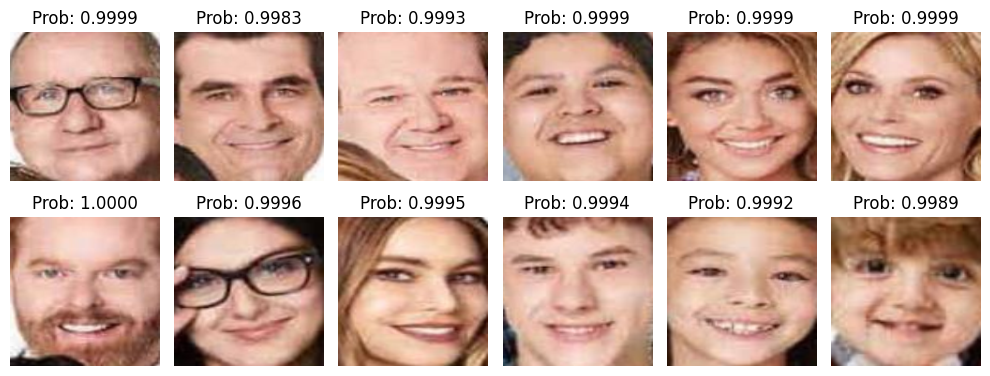

In [9]:
# Plot extracted faces with matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=int(np.ceil(len(faces)/2)), figsize=(10, 4))
axs = axs.flatten()
for i in range(faces.shape[0]):
    face = convert_to_matplotlib_rgb(faces[i])
    # add a title with the probability
    axs[i].set_title(f'Prob: {probs[i]:.4f}')
    axs[i].imshow(face)
    axs[i].axis('off')
fig.tight_layout()

print(faces[0])

# Embedding of faces

Once the faces in the image have been identified, the next step is to obtain a numerical transformation that represents each face’s unique characteristics. The resulting numerical vector is known as an *embedding* or *encoding*.

Deep learning models (convolutional neural networks) capable of generating face embeddings are not easy to train. Fortunately, several pre-trained models are available in Python. Two of the most common are:

- [face_recognition_model_v1](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) from the **dlib** library. This model generates a 128-dimensional embedding.
- [InceptionResnetV1](https://github.com/timesler/facenet-pytorch) from the **facenet-pytorch** library. This model generates a 512-dimensional embedding.

To build this type of model, a classification network is first trained on a dataset containing many individuals. Once the network is trained, the final *softmax* layer is removed so that the model’s output becomes a numerical vector.

In this document, the model used is `InceptionResnetV1`, specifically the version trained on the *VGGFace2* dataset.  
For more details about this type of model, refer to the [VGGFace2 paper](https://arxiv.org/pdf/1710.08092.pdf).


<div align="center">
<img src="../images/diagram-face-embedding.png" style="width: 750px;">
</div>

<center><font size='2.5'> <i>Diagram of a face embedding process.</i></font></center>

In [10]:
# Embeding of faces
# ==============================================================================
embeddings = face_detector.calculate_embeddings(face_images=faces)
print(f"Shape: {embeddings.shape}")
embeddings

Shape: torch.Size([12, 512])


tensor([[ 7.3119e-02,  1.3807e-02, -2.0866e-02,  ..., -5.1862e-02,
          5.5240e-02,  4.7610e-03],
        [-6.3946e-02, -1.7960e-02, -3.9687e-02,  ...,  6.9325e-02,
         -9.6542e-02, -9.4992e-02],
        [ 3.1438e-02,  6.8282e-02, -6.3409e-03,  ..., -9.6854e-05,
          3.9739e-02, -1.2795e-02],
        ...,
        [ 4.7704e-02, -1.6753e-02,  3.7802e-02,  ..., -2.9759e-02,
         -3.5267e-02, -1.2076e-02],
        [ 4.3862e-02, -7.2438e-03,  2.1455e-02,  ..., -1.0147e-02,
          1.3584e-02,  4.7367e-03],
        [-4.3593e-03, -2.1744e-02,  3.1877e-02,  ..., -6.5899e-02,
          2.2239e-02,  1.8709e-02]])

# Measuring face similarity with embeddings

The goal of obtaining a numerical representation of faces (*embeddings*) is to quantify how similar they are to one another.  
Two common ways to calculate this similarity are by using the Euclidean distance or the cosine distance between embeddings.  The smaller the distance, the greater the similarity between the faces.

$$ \text{similarity} = 1 - \text{distance} $$

Below is an example where one image is compared against two others: the first belongs to the same person, **Phil Dunphy**, and the second to **Cameron Tucker**.


In [11]:
# Extraction of faces
# ==============================================================================
phil_1 = face_detector.extract_faces(image=image_1)[0][0]
phil_2 = face_detector.extract_faces(image=image_2)[0][1]
cameron = face_detector.extract_faces(image=image_2)[0][2]

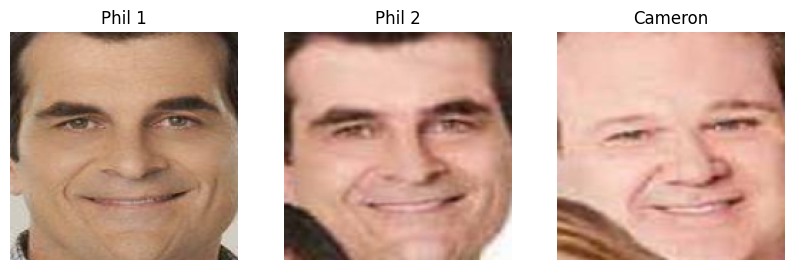

In [12]:
# Plot extracted faces
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

face = convert_to_matplotlib_rgb(phil_1)
axs[0].imshow(face)
axs[0].set_title('Phil 1')
axs[0].axis('off')

face = convert_to_matplotlib_rgb(phil_2)
axs[1].imshow(face)
axs[1].set_title('Phil 2')
axs[1].axis('off')

face = convert_to_matplotlib_rgb(cameron)
axs[2].imshow(face)
axs[2].set_title('Cameron')
axs[2].axis('off');

Once the 3 faces are extracted from the images, their *embeddings* are created, and the similarities between them are calculated using the Euclidean distance.

In [13]:
# Embeddings
# ==============================================================================
embedding_phil_1 = face_detector.calculate_embeddings(face_images=phil_1.reshape((1, 3, 160, 160))).flatten()
embedding_phil_2 = face_detector.calculate_embeddings(face_images=phil_2.reshape((1, 3, 160, 160))).flatten()
embedding_cameron = face_detector.calculate_embeddings(face_images=cameron.reshape((1, 3, 160, 160))).flatten()

In [14]:
# Distance between embeddings
# ==============================================================================
print(f"Distance between the same image Phil: {1 - euclidean(embedding_phil_1, embedding_phil_1)}")
print(f"Distance between the two images of Phil: {1 - euclidean(embedding_phil_1, embedding_phil_2)}")
print(f"Distance between Phil and Cameron: {1 - euclidean(embedding_phil_1, embedding_cameron)}")

Distance between the same image Phil: 1.0
Distance between the two images of Phil: 0.40968143939971924
Distance between Phil and Cameron: -0.3885413408279419


It can be observed that the similarity between the two images of Phil is significantly higher than the similarity between Phil and Cameron, indicating that the embeddings effectively capture the facial features that differentiate individuals.

# Collection of reference embeddings

To identify who a face belongs to, it is necessary to compare it against a database that contains a reference *embedding* for each identity.

The newly detected face is compared against all the reference embeddings in the database. If the similarity between the new embedding and any of the reference embeddings is above a certain threshold, the identity associated with that reference embedding is assigned to the detected face. If no similarities are above the threshold, the face is classified as "unknown."

**DeepFaceRecognition** provides the class `ReferenceEmbeddings` to facilitate the management of a database of reference embeddings. Given a path to a folder with images of known individuals, this class can automatically create and store the reference embeddings for each identity.

The image or images of each person are assumed to be located in a subfolder named after that person's identity.

In [15]:
# Download reference images
# ==============================================================================
url = (
    "https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/"
    "raw/master/images/imagenes_referencia_reconocimiento_facial.zip"
)
extract_dir = "./images/reference_images"
os.makedirs(extract_dir, exist_ok=True)
zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

print("Images successfully downloaded and extracted to:", extract_dir)

Images successfully downloaded and extracted to: ./images/reference_images


In [16]:
# Create reference embeddings from a folder of images
# ==============================================================================
reference_embeddings = ReferenceEmbeddings(
    folder_path='./images/reference_images'
)

reference_embeddings.calculate_reference_embeddings()
reference_embeddings

Processing identity: JayPritchett
  Reading image: ./images/reference_images/JayPritchett/descarga (2).jpg
  Reading image: ./images/reference_images/JayPritchett/JayPritchett.png
Processing identity: AlexDunphy
  Reading image: ./images/reference_images/AlexDunphy/5e8f3e2373d0c84a052dc5e2.jpg
  Reading image: ./images/reference_images/AlexDunphy/alex-black-floral-ruffle-blouse.jpg
  Reading image: ./images/reference_images/AlexDunphy/AlexDunphy.png
Processing identity: CameronTucker
  Reading image: ./images/reference_images/CameronTucker/descarga.jpg
  Reading image: ./images/reference_images/CameronTucker/CameronTucker.png
Processing identity: JoePritchett
  Reading image: ./images/reference_images/JoePritchett/images (1).jpg
  Reading image: ./images/reference_images/JoePritchett/images.jpg
  Reading image: ./images/reference_images/JoePritchett/Joe_Pritchett.jpg
  Reading image: ./images/reference_images/JoePritchett/descarga.jpg
  Reading image: ./images/reference_images/JoePritc

-------------------
ReferenceEmbeddings
-------------------
Number of identities: 12
Number of images per identity: {'JayPritchett': 2, 'AlexDunphy': 3, 'CameronTucker': 2, 'JoePritchett': 5, 'MitchellPritchett': 3, 'HaleyDunphy': 4, 'PhilDunphy': 4, 'MannyDelgado': 6, 'LilyTucker-Pritchett': 4, 'ClaireDunphy': 3, 'GloriaPritchett': 3, 'LukeDunphy': 4}
Source folder: ./images/reference_images
Save path: None
Device: None
Minimum face size: 20
Detection thresholds: [0.6, 0.7, 0.7]
Minimum confidence for detection: 0.5
Verbose: True

Once the reference embeddings have been created, they can be loaded into the `FaceDetector` class to perform face recognition on new images using the `load_reference_embeddings` method. Then, the `identify_faces` method can be used to detect and recognize faces in new images.


In [17]:
# Load reference embeddings into the face_detector
# ==============================================================================
face_detector.load_reference_embeddings(reference_embeddings)

In [18]:
# Detect and recognize faces in a image
# ==============================================================================
identities, similarities = face_detector.identify_faces(
    embeddings=embeddings
)
print(f"Identidades: {identities}")
print(f"Similitudes: {similarities}")

----------------
Identified faces
----------------
Face 0: Identity: JayPritchett, Similarity: 0.69
Face 1: Identity: PhilDunphy, Similarity: 0.92
Face 2: Identity: CameronTucker, Similarity: 0.80
Face 3: Identity: MannyDelgado, Similarity: 0.87
Face 4: Identity: HaleyDunphy, Similarity: 0.75
Face 5: Identity: ClaireDunphy, Similarity: 0.78
Face 6: Identity: MitchellPritchett, Similarity: 0.61
Face 7: Identity: AlexDunphy, Similarity: 0.62
Face 8: Identity: GloriaPritchett, Similarity: 0.68
Face 9: Identity: LukeDunphy, Similarity: 0.79
Face 10: Identity: LilyTucker-Pritchett, Similarity: 0.80
Face 11: Identity: JoePritchett, Similarity: 0.77
Identidades: ['JayPritchett', 'PhilDunphy', 'CameronTucker', 'MannyDelgado', 'HaleyDunphy', 'ClaireDunphy', 'MitchellPritchett', 'AlexDunphy', 'GloriaPritchett', 'LukeDunphy', 'LilyTucker-Pritchett', 'JoePritchett']
Similitudes: [0.6871325969696045, 0.9191560745239258, 0.7987002730369568, 0.874779462814331, 0.746529757976532, 0.7806506752967834, 0

Is it also possible detect, identify, and plot the bounding boxes of the recognized faces in a single step using the `detect_and_identify_faces` method.

----------------
Scanned image
----------------
Detected faces: 12
Detected faces with minimum confidence: 12
Bounding box correction applied: True
Bounding box coordinates: [[293, 64, 402, 194], [505, 89, 605, 224], [108, 95, 210, 227], [427, 207, 529, 333], [47, 235, 145, 361], [1069, 134, 1165, 262], [682, 126, 778, 248], [659, 291, 750, 402], [886, 128, 968, 250], [239, 245, 326, 355], [931, 496, 1012, 613], [816, 663, 889, 751]]
Bounding box confidence: [0.9999438524246216, 0.9982789754867554, 0.999267041683197, 0.9998809099197388, 0.9999357461929321, 0.9999068975448608, 0.9999818801879883, 0.9996474981307983, 0.9995021820068359, 0.9993504881858826, 0.9991905093193054, 0.9989155530929565]

----------------
Identified faces
----------------
Face 0: Identity: JayPritchett, Similarity: 0.68
Face 1: Identity: PhilDunphy, Similarity: 0.92
Face 2: Identity: CameronTucker, Similarity: 0.80
Face 3: Identity: MannyDelgado, Similarity: 0.88
Face 4: Identity: HaleyDunphy, Similarity: 0.74
Fa

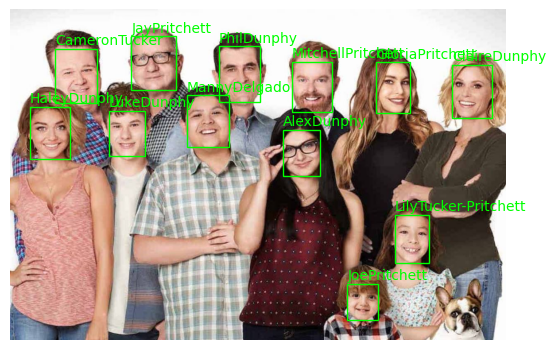

In [19]:
face_detector.detect_and_identify_faces(
    image=image_2,
)

# Pipeline for face detection and recognition

All the steps described above can be combined into a single pipeline for face recognition in images, videos, or real-time video streams.

## Pipeline for face recognition in images

In [20]:
# Create reference embeddings from a folder of images
# ==============================================================================
reference_embeddings = ReferenceEmbeddings(
    folder_path='./images/reference_images',
    verbose = False
)

reference_embeddings.calculate_reference_embeddings()
reference_embeddings

-------------------
ReferenceEmbeddings
-------------------
Number of identities: 12
Number of images per identity: {'JayPritchett': 2, 'AlexDunphy': 3, 'CameronTucker': 2, 'JoePritchett': 5, 'MitchellPritchett': 3, 'HaleyDunphy': 4, 'PhilDunphy': 4, 'MannyDelgado': 6, 'LilyTucker-Pritchett': 4, 'ClaireDunphy': 3, 'GloriaPritchett': 3, 'LukeDunphy': 4}
Source folder: ./images/reference_images
Save path: None
Device: None
Minimum face size: 20
Detection thresholds: [0.6, 0.7, 0.7]
Minimum confidence for detection: 0.5
Verbose: False

In [21]:
# Load reference embeddings into the face detector
# ==============================================================================
face_detector.load_reference_embeddings(reference_embeddings)

----------------
Scanned image
----------------
Detected faces: 12
Detected faces with minimum confidence: 12
Bounding box correction applied: True
Bounding box coordinates: [[293, 64, 402, 194], [505, 89, 605, 224], [108, 95, 210, 227], [427, 207, 529, 333], [47, 235, 145, 361], [1069, 134, 1165, 262], [682, 126, 778, 248], [659, 291, 750, 402], [886, 128, 968, 250], [239, 245, 326, 355], [931, 496, 1012, 613], [816, 663, 889, 751]]
Bounding box confidence: [0.9999438524246216, 0.9982789754867554, 0.999267041683197, 0.9998809099197388, 0.9999357461929321, 0.9999068975448608, 0.9999818801879883, 0.9996474981307983, 0.9995021820068359, 0.9993504881858826, 0.9991905093193054, 0.9989155530929565]

----------------
Identified faces
----------------
Face 0: Identity: JayPritchett, Similarity: 0.68
Face 1: Identity: PhilDunphy, Similarity: 0.92
Face 2: Identity: CameronTucker, Similarity: 0.80
Face 3: Identity: MannyDelgado, Similarity: 0.88
Face 4: Identity: HaleyDunphy, Similarity: 0.74
Fa

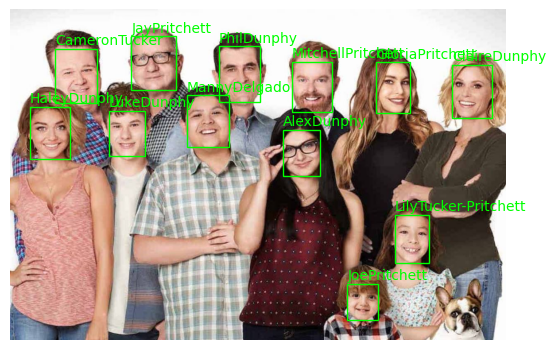

In [22]:
# Detect and recognize faces in an image
# ==============================================================================
face_detector.detect_and_identify_faces(
    image=image_2,
)

## Pipeline for face recognition in videos

Processing videos requires handling each of its frames, making it computationally intensive. It is recommended to use GPUs. The video used for this example can be downloaded from the following [link](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/raw/master/images/video_modern_family.mp4).

In [23]:
# Detect and recognize faces in a video
# ==============================================================================
face_detector.detect_and_identify_faces_video(
    video_path='./videos/video_modern_family.mp4',
    output_path='./videos/output_test.mp4'
)

OSError: Cannot open video file ./videos/video_modern_family.mp4

<div>
<img src='./videos/video_processed.gif' width="500"/>
</div>

## Pipeline for face recognition in webcam

The argument `capture_index` specifies which camera to use (0 for the default camera, 1 for an external camera, etc.). The argument `skip_frames` allows skipping a certain number of frames between each processing step to improve performance. The argument `show` indicates whether to display the video with the detected and identified faces in real-time.

In [25]:
face_detector.detect_and_identify_faces_webcam(
    capture_index=0,
    skip_frames=2,
    show=True
)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/joaquin/miniconda3/envs/face_detection/lib/python3.12/site-packages/cv2/qt/plugins"


KeyboardInterrupt: 

# Session Information

In [28]:
import session_info
session_info.show(html=False)

-----
PIL                 12.0.0
cv2                 4.12.0
matplotlib          3.10.7
numpy               2.2.6
openfacekit         0.1.0
scipy               1.16.3
session_info        v1.0.1
torch               2.7.1+cu126
-----
IPython             9.6.0
jupyter_client      8.6.3
jupyter_core        5.9.1
-----
Python 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]
Linux-6.14.0-34-generic-x86_64-with-glibc2.39
-----
Session information updated at 2025-11-03 22:37


# How to Cite


**How to cite this document?**

If you use this document or any part of it, we appreciate your citation. Thank you very much!

<p style="text-align:left"><font size="3" color="#555">
Face Detection and Recognition with Deep Learning and Python by Joaquín Amat Rodrigo, available under an Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) license at https://cienciadedatos.net/documentos/py34-reconocimiento-facial-deeplearning-python.html
</font></p>

<strong>Did you like the article? Your support is important</strong>

Your contribution will help me continue generating free educational content. Thank you very much! &#128522;

<a href="https://www.paypal.com/donate/?hosted_button_id=6NULYFYDKFTQL"><img src="https://www.paypalobjects.com/en_US/ES/i/btn/btn_donateCC_LG.gif" style="text-align: center"/></a>

<a href="https://github.com/sponsors/JoaquinAmatRodrigo" target="_blank" title="Become a GitHub Sponsor">
<img style="margin-bottom: 1em; max-width: 200px;" src="../images/github_sponsor_button.png" alt="Become a GitHub Sponsor" style="text-align: center">
</a>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg" /></a><br/>

This document created by Joaquín Amat Rodrigo is licensed under an <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a> license.

<p style="text-align:left"><font size="3" color="#555">You are allowed to:</font></p>

<ul>
<li>
  <p style="text-align:left"><font size="3" color="#555">Share: copy and redistribute the material in any medium or format.</font></p>
</li>
<li>
  <p style="text-align:left"><font size="3" color="#555">Adapt: remix, transform, and build upon the material.</font></p>
</li>
</ul>

<p style="text-align:left"><font size="3" color="#555">Under the following terms:</font></p>

<ul>
<li>
  <p style="text-align:left"><font size="3" color="#555">Attribution: You must give <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-appropriate-credit">appropriate credit</a>, provide a link to the license, and <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-indicate-changes">indicate if changes were made</a>. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.</font></p>
</li>

<li>
  <p style="text-align:left"><font size="3" color="#555">Non-Commercial: You may not use the material for <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-commercial-purposes">commercial purposes</a>.</font></p>
</li>

<li>
  <p style="text-align:left"><font size="3" color="#555">ShareAlike: If you remix, transform, or build upon the material, you must distribute your contributions under the <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es#ref-same-license">same license</a> as the original.</font></p>
</li>
</ul>